# Merge Datasets and Analysis

# General

## Imports

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Constants

In [2]:
PATH_PROTECED_AREA = 'data/OECD/protected_areas_2020.csv'
PATH_LAND_COVER = 'data/OECD/LAND_COVER_2018_DATA.csv'
PATH_AIR = 'data/OECD/greenhouse_gases_2020_pred.csv'
PATH_CLIMATE = 'data/climate/climate_features.csv'
PATH_IUCN = 'data/IUCN/scraped'
PATH_IUCN_REL = 'data/IUCN/THREATENED_RELATIVE_BY_GROUP.csv'
PATHS_COUN = [PATH_PROTECED_AREA, PATH_LAND_COVER, PATH_CLIMATE, PATH_AIR] # AIR IS MISSING
RANDOM_STATE = 42

# IUCN Data

## Load and Concatenate

In [3]:
iucn_list = []
for _, _, files in os.walk(PATH_IUCN):
    for file in files:
        temp = pd.read_csv(PATH_IUCN + '/' + file)
        temp['Country'] = file.split('.csv')[0]
        iucn_list.append(temp)
iucn_data = pd.concat(iucn_list)

## Analysis

### General Information

In [4]:
iucn_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136624 entries, 0 to 1128
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   kingdom_class    136624 non-null  object
 1   common_name      93221 non-null   object
 2   scientific_name  136624 non-null  object
 3   trend            133638 non-null  object
 4   region           136624 non-null  object
 5   threat_level     136624 non-null  object
 6   Country          136624 non-null  object
dtypes: object(7)
memory usage: 8.3+ MB


### Check Uniue Values

In [5]:
for c in iucn_data.columns:
    print('Column >>{}<< contains {} unique values.'.format(c, iucn_data[c].nunique()))

Column >>kingdom_class<< contains 32 unique values.
Column >>common_name<< contains 30138 unique values.
Column >>scientific_name<< contains 52327 unique values.
Column >>trend<< contains 4 unique values.
Column >>region<< contains 13 unique values.
Column >>threat_level<< contains 9 unique values.
Column >>Country<< contains 65 unique values.


### Explore Columns Containing NULL Values

#### common_name

In [6]:
print('common_name contains {} unique values.'.format(
    iucn_data['common_name'].nunique()))

common_name contains 30138 unique values.


In [7]:
print('{} entries have missing values for the common_name column.'.format(
    iucn_data['common_name'].isna().sum()))

43403 entries have missing values for the common_name column.


In [8]:
i_null_cn = iucn_data[iucn_data['common_name'].isna()].index

--> These missing values can probably be neglected, because we can use the scientific name as identifier.

#### trend

In [9]:
print('trend contains {} unique values, which are: {}.'.format(
    iucn_data['trend'].nunique(), iucn_data['trend'].unique()))

trend contains 4 unique values, which are: ['Unknown' 'Stable' 'Decreasing' nan 'Increasing'].


In [10]:
print('{} entries have missing values for the trend column.'.format(
    iucn_data['trend'].isna().sum()))

2986 entries have missing values for the trend column.


<AxesSubplot:>

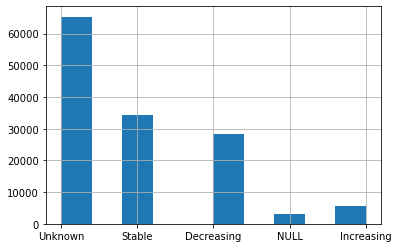

In [11]:
temp_iucn = iucn_data.copy()
temp_iucn.loc[temp_iucn['trend'].isna(), 'trend'] = 'NULL'
temp_iucn['trend'].hist()

In [12]:
print(
    'The dataset contains {} entries with available trend information (not Null or Unknown).'
    .format(
        len(iucn_data[(iucn_data['trend'].isna() == False)
                      & (iucn_data['trend'] != 'Unknown')])))

The dataset contains 68333 entries with available trend information (not Null or Unknown).


**NOTE: This is an issue and we have to think about a strategy how to deal with these missing/unknown values.**
Maybe we can check if these entries have some special characteristics.

# Country Characteristics Data

## Load and Merge

In [13]:
coun_list = []
country_sets = []
for file in PATHS_COUN:
    print(file)
    temp = pd.read_csv(file)
    coun_list.append(temp)
    country_sets.append(set(temp['Country']))

data/OECD/protected_areas_2020.csv
data/OECD/LAND_COVER_2018_DATA.csv
data/climate/climate_features.csv
data/OECD/greenhouse_gases_2020_pred.csv


In [14]:
intersect_countries = country_sets[0].intersection(
    country_sets[1], country_sets[2], country_sets[3])  ## add country_sets[3]
print(
    'The Country Characterisitcs Datasets contain {} intersecting countries, which are: {}'
    .format(len(intersect_countries), intersect_countries))

The Country Characterisitcs Datasets contain 42 intersecting countries, which are: {'Australia', 'Hungary', 'Estonia', 'Russia', 'New Zealand', 'United States', 'France', 'Argentina', 'Luxembourg', 'Iceland', 'India', 'Canada', 'Korea', 'Portugal', 'Czech Republic', 'Denmark', 'Italy', 'Brazil', 'Japan', 'Israel', 'Poland', 'Slovak Republic', 'Slovenia', 'Switzerland', 'United Kingdom', 'Norway', 'Chile', 'Costa Rica', 'Austria', 'Latvia', 'Indonesia', 'Spain', 'Colombia', 'Belgium', 'Mexico', 'Finland', 'Lithuania', 'Sweden', 'Greece', 'Ireland', 'Netherlands', 'Germany'}


--> Join Datasets on those countries.

In [15]:
coun_data = coun_list[0]
for coun in coun_list[1:]:
    coun_data = pd.merge(coun_data, coun, on='Country', how='inner')
coun_data.head()

,Country,perc_area_protected_all_obj,perc_area_protected_obj_2,perc_area_protected_obj_3,perc_area_protected_obj_4,perc_area_protected_obj_1a,perc_area_protected_obj_1b,perc_area_protected_no_obj,perc_area_protected_obj_5,perc_area_protected_obj_6,...,gain_percentage,temp_difference,Unnamed: 0,CH4,CO2,HFC,N2O,NF3,PFC,SF6
0,Argentina,8.39,1.84,0.04,0.19,0.27,0.03,1.46,0.33,4.09,...,0.500525,0.072246,0,1.828861,4.710241,0.014370,1.002114,-1.000000,0.003744,0.000042
1,Australia,19.20,4.17,0.24,0.27,2.01,0.57,0.34,0.98,10.63,...,0.969423,0.214683,1,4.382540,16.642911,0.479420,0.804808,-1.000000,0.009443,0.009144
2,Austria,28.54,2.38,0.01,5.80,0.01,0.12,4.62,15.35,0.20,...,24.241043,1.498389,2,0.728541,7.549433,0.207606,0.398982,0.001868,0.003680,0.043241
3,Belgium,24.97,0.07,0.00,1.54,0.00,0.00,9.19,12.59,1.59,...,12.044550,1.167659,3,0.688260,8.787278,0.391962,0.500037,0.000057,0.011516,0.008337
4,Brazil,29.80,4.13,0.07,0.03,2.06,0.00,11.83,4.58,6.78,...,3.703937,0.929317,4,1.683181,2.566549,-1.000000,0.894033,-1.000000,-1.000000,-1.000000


## Analysis

### General Information

In [16]:
coun_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42 entries, 0 to 41
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Country                      42 non-null     object 
 1   perc_area_protected_all_obj  42 non-null     float64
 2   perc_area_protected_obj_2    42 non-null     float64
 3   perc_area_protected_obj_3    42 non-null     float64
 4   perc_area_protected_obj_4    42 non-null     float64
 5   perc_area_protected_obj_1a   42 non-null     float64
 6   perc_area_protected_obj_1b   42 non-null     float64
 7   perc_area_protected_no_obj   42 non-null     float64
 8   perc_area_protected_obj_5    42 non-null     float64
 9   perc_area_protected_obj_6    42 non-null     float64
 10  Artificial surfaces          42 non-null     float64
 11  Bare area                    42 non-null     float64
 12  Cropland                     42 non-null     float64
 13  Grassland             

There are no missing values in the dataset.

In [17]:
coun_data.describe()

,perc_area_protected_all_obj,perc_area_protected_obj_2,perc_area_protected_obj_3,perc_area_protected_obj_4,perc_area_protected_obj_1a,perc_area_protected_obj_1b,perc_area_protected_no_obj,perc_area_protected_obj_5,perc_area_protected_obj_6,Artificial surfaces,...,gain_percentage,temp_difference,Unnamed: 0,CH4,CO2,HFC,N2O,NF3,PFC,SF6
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,...,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,22.282857,4.151667,0.362381,2.964762,0.445714,0.872619,6.900476,4.782381,1.533333,0.026339,...,10.864795,0.987359,22.095238,1.284412,7.478007,0.164214,0.586226,-0.666490,-0.154093,-0.036179
std,10.766357,5.984902,1.917474,3.469978,0.676599,1.827691,8.767212,5.999103,2.741055,0.027342,...,12.305045,0.448411,12.957359,1.194647,4.017188,0.297642,0.349903,0.477372,0.384327,0.219119
min,5.640000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-24.178355,0.072246,0.000000,0.236113,1.278950,-1.000000,0.092906,-1.000000,-1.000000,-1.000000
25%,14.287500,0.652500,0.000000,0.440000,0.000000,0.000000,0.472500,0.110000,0.000000,0.005924,...,3.832235,0.659961,11.250000,0.750174,4.848182,0.109285,0.345235,-1.000000,0.000021,0.002429
50%,20.370000,2.025000,0.020000,1.555000,0.070000,0.005000,3.375000,1.430000,0.085000,0.015773,...,9.547614,0.943211,22.500000,0.893499,6.846338,0.176891,0.481730,-1.000000,0.003712,0.007283
75%,27.892500,4.812500,0.070000,3.877500,0.545000,0.525000,11.290000,7.780000,1.552500,0.040661,...,17.897105,1.382112,32.750000,1.261372,9.078078,0.322812,0.849686,0.000009,0.012341,0.010464
max,53.530000,32.610000,12.470000,14.740000,2.180000,7.530000,40.300000,25.240000,10.630000,0.113337,...,43.855657,1.852533,44.000000,7.017958,16.642911,0.550778,1.554079,0.002234,0.216726,0.128989


In [18]:
coun_data['Country'].nunique()

42

# Full Data

## Merge both datasets

### Check Keys (countries)

In [19]:
iucn_countries = set(iucn_data['Country'].unique())
char_countries = set(coun_data['Country'].unique())
print('IUCN \ CHAR: {}'.format(iucn_countries.difference(char_countries)))
print('CHAR \ IUCN: {}'.format(char_countries.difference(iucn_countries)))

IUCN \ CHAR: {'Cyprus', 'Turkmenistan', 'Bulgaria', 'Moldova', 'Tajikistan', 'Saudi Arabia', 'Georgia', 'South Africa', 'Armenia', 'Puerto Rico', 'New Caledonia', 'Belarus', 'Kazakhstan', 'Croatia', 'Greenland', 'Azerbaijan', 'Peru', 'Malta', 'Romania', 'Northern Mariana Islands', 'Kyrgyzstan', 'Ukraine', 'Uzbekistan'}
CHAR \ IUCN: set()


In [20]:
oecd_list = [
    'AUSTRALIA', 'AUSTRIA', 'BELGIUM', 'CANADA', 'CHILE', 'COLOMBIA',
    'CZECH REPUBLIC', 'DENMARK', 'ESTONIA', 'FINLAND', 'FRANCE', 'GERMANY',
    'GREECE', 'HUNGARY', 'ICELAND', 'IRELAND', 'ISRAEL', 'ITALY', 'JAPAN',
    'KOREA', 'LATVIA', 'LITHUANIA', 'LUXEMBOURG', 'MEXICO', 'NETHERLANDS',
    'NEW ZEALAND', 'NORWAY', 'POLAND', 'PORTUGAL', 'SLOVAK REPUBLIC',
    'SLOVENIA', 'SPAIN', 'SWEDEN', 'SWITZERLAND', 'TURKEY', 'UNITED KINGDOM',
    'UNITED STATES'
]
oecd_list = [c.title() for c in oecd_list]
len(oecd_list)

37

In [21]:
set(oecd_list).difference(iucn_countries)

{'Turkey'}

In [22]:
set(oecd_list).difference(char_countries)

{'Turkey'}

In [23]:
iucn_diff_list = [c for c in iucn_countries.difference(char_countries)]
set(iucn_diff_list).intersection(set(oecd_list))

set()

In [24]:
#i

### Rename Country Data to Match IUCN Data

In [25]:
coun_data.loc[coun_data['Country'] == 'New Zealand', 'Country'] = 'New_Zealand'
coun_data.loc[coun_data['Country'] == 'Slovak Republic', 'Country'] = 'Slovakia'
coun_data.loc[coun_data['Country'] == 'United Kingdom', 'Country'] = 'United_Kingdom'
coun_data.loc[coun_data['Country'] == 'United States', 'Country'] = 'United_States'
coun_data.loc[coun_data['Country'] == 'Czech Republic', 'Country'] = 'Czechia'
coun_data.loc[coun_data['Country'] == 'Korea', 'Country'] = 'Korea,_Republic_of'

### Merge 

In [26]:
full_data = iucn_data.merge(coun_data, on='Country', how='inner')
full_data['Country'].nunique()

36

In [27]:
full_data.columns.values

array(['kingdom_class', 'common_name', 'scientific_name', 'trend',
       'region', 'threat_level', 'Country', 'perc_area_protected_all_obj',
       'perc_area_protected_obj_2', 'perc_area_protected_obj_3',
       'perc_area_protected_obj_4', 'perc_area_protected_obj_1a',
       'perc_area_protected_obj_1b', 'perc_area_protected_no_obj',
       'perc_area_protected_obj_5', 'perc_area_protected_obj_6',
       'Artificial surfaces', 'Bare area', 'Cropland', 'Grassland',
       'Inland water', 'Shrubland', 'Sparse vegetation', 'Tree cover',
       'Wetland', 'temp_slope', 'gain_percentage', 'temp_difference',
       'Unnamed: 0', 'CH4', 'CO2', 'HFC', 'N2O', 'NF3', 'PFC', 'SF6'],
      dtype=object)

### Merge with the relative number of threatened species
For the prediction of the number of species per country relative to the number of total described species, we merge our coun_data with the relative number of threatened species per country. After those steps we have got 36 countries left, with 29 different characteristics for each one. We also have the relative number of threatened species by the taxonomic group for the major land living groups. Those are mammals, insects, amphibians, birds and reptiles. The maximum value for threatened species is 16.7%, while the minimum lies at 1.7% and there are on average 8.4% of the documented species threatened across all countries. The highest mean by taxonomic group can be seen for amphibians with 11.4% while the lowest can be seen for birds with  5.1%.

In [28]:
threatened_relative = pd.read_csv(PATH_IUCN_REL)
threatened_relative = threatened_relative.rename(columns={'Unnamed: 0': 'Country'})

In [29]:
threatened_countries = set(threatened_relative['Country'].unique())
print('THREAT \ CHAR: {}'.format(threatened_countries.difference(char_countries)))
print('CHAR \ THREAT: {}'.format(char_countries.difference(threatened_countries)))

THREAT \ CHAR: {'Cyprus', 'Turkmenistan', 'Bulgaria', 'Moldova', 'Tajikistan', 'Saudi Arabia', 'Georgia', 'South Africa', 'Armenia', 'Puerto Rico', 'New Caledonia', 'Belarus', 'Kazakhstan', 'Croatia', 'Greenland', 'Azerbaijan', 'Peru', 'Malta', 'Romania', 'Northern Mariana Islands', 'Kyrgyzstan', 'Ukraine', 'Uzbekistan'}
CHAR \ THREAT: set()


In [30]:
full_threatened = threatened_relative.merge(coun_data, on='Country', how='inner')
full_threatened.head()

,Country,total_threatened,mammals_threatened,insects_threatened,amphibians_threatened,birds_threatened,reptiles_threatened,mammals_resident,insects_resident,amphibians_resident,...,gain_percentage,temp_difference,Unnamed: 0,CH4,CO2,HFC,N2O,NF3,PFC,SF6
0,Argentina,0.0791,0.1003,0.0744,0.2061,0.0519,0.0771,True,True,True,...,0.500525,0.072246,0,1.828861,4.710241,0.014370,1.002114,-1.000000,0.003744,0.000042
1,Australia,0.1120,0.1864,0.1403,0.2108,0.0716,0.0766,True,True,True,...,0.969423,0.214683,1,4.382540,16.642911,0.479420,0.804808,-1.000000,0.009443,0.009144
2,Austria,0.0628,0.0568,0.0867,0.0000,0.0426,0.0769,True,True,True,...,24.241043,1.498389,2,0.728541,7.549433,0.207606,0.398982,0.001868,0.003680,0.043241
3,Belgium,0.0378,0.0417,0.0544,0.0000,0.0303,0.0000,True,True,True,...,12.044550,1.167659,3,0.688260,8.787278,0.391962,0.500037,0.000057,0.011516,0.008337
4,Brazil,0.0861,0.1360,0.0807,0.0430,0.0914,0.0766,True,True,True,...,3.703937,0.929317,4,1.683181,2.566549,-1.000000,0.894033,-1.000000,-1.000000,-1.000000


In [31]:
#drop column that arbitraly occured during merging before
full_threatened = full_threatened.drop(columns=['Unnamed: 0'])
#descriptive satistics for our final data frame
full_threatened.describe()

,total_threatened,mammals_threatened,insects_threatened,amphibians_threatened,birds_threatened,reptiles_threatened,perc_area_protected_all_obj,perc_area_protected_obj_2,perc_area_protected_obj_3,perc_area_protected_obj_4,...,temp_slope,gain_percentage,temp_difference,CH4,CO2,HFC,N2O,NF3,PFC,SF6
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,...,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,3.600000e+01,36.000000
mean,0.084056,0.101114,0.087264,0.114533,0.051697,0.095097,21.890278,4.285278,0.058889,2.898333,...,0.032756,10.010823,0.938828,1.156474,7.097104,0.144013,0.561717,-0.694300,-1.818770e-01,-0.046840
std,0.043261,0.070868,0.051773,0.156417,0.021114,0.111864,10.988145,6.315960,0.117492,3.546239,...,0.012915,12.942997,0.446922,0.820514,3.919144,0.313502,0.306269,0.467397,4.091898e-01,0.234670
min,0.016700,0.000000,0.000000,0.000000,0.016000,0.000000,5.640000,0.000000,0.000000,0.010000,...,0.006156,-24.178355,0.072246,0.236113,1.278950,-1.000000,0.092906,-1.000000,-1.000000e+00,-1.000000
25%,0.047375,0.050100,0.060475,0.000000,0.037575,0.000000,14.135000,0.642500,0.000000,0.397500,...,0.022128,3.639039,0.603596,0.740512,4.616156,0.103406,0.357740,-1.000000,9.067425e-07,0.002302
50%,0.071400,0.089700,0.083700,0.032150,0.044300,0.076750,19.625000,2.025000,0.015000,1.555000,...,0.034182,8.858960,0.903967,0.893499,6.477036,0.158652,0.481730,-1.000000,3.587118e-03,0.007283
75%,0.121650,0.138025,0.100175,0.207275,0.062050,0.153800,26.577500,4.935000,0.050000,3.712500,...,0.038572,15.000800,1.220734,1.195826,8.839010,0.279662,0.819767,0.000005,1.057792e-02,0.010420
max,0.166500,0.294000,0.234400,0.563000,0.111900,0.500000,53.530000,32.610000,0.590000,14.740000,...,0.058883,43.855657,1.852533,4.382540,16.642911,0.550778,1.431682,0.002234,2.167259e-01,0.046683


# Trends

## Preprocessing

### Transform Trends to [-1, 1]

In [32]:
full_data = full_data.dropna()
full_data = full_data.drop('Unnamed: 0', axis=1)
full_data = full_data[full_data['trend'] != 'Unknown']
full_data.loc[full_data['trend'] == 'Decreasing', 'trend_num'] = -1
full_data.loc[full_data['trend'] == 'Stable', 'trend_num'] = 0
full_data.loc[full_data['trend'] == 'Increasing', 'trend_num'] = 1
full_data.head()

,kingdom_class,common_name,scientific_name,trend,region,threat_level,Country,perc_area_protected_all_obj,perc_area_protected_obj_2,perc_area_protected_obj_3,...,gain_percentage,temp_difference,CH4,CO2,HFC,N2O,NF3,PFC,SF6,trend_num
1,animalia — gastropoda,Lapidary Snail,Helicigona lapicida,Stable,"Global, Europe",Least Concern,Netherlands,21.36,2.93,0.0,...,13.518773,1.279099,1.004478,9.295129,0.095269,0.484523,-1.0,0.00946,0.007178,0.0
2,animalia — gastropoda,Moss Chrysalis Snail,Pupilla muscorum,Decreasing,"Global, Europe",Least Concern,Netherlands,21.36,2.93,0.0,...,13.518773,1.279099,1.004478,9.295129,0.095269,0.484523,-1.0,0.00946,0.007178,-1.0
5,animalia — mammalia,Lesser Horseshoe Bat,Rhinolophus hipposideros,Decreasing,Global,Least Concern,Netherlands,21.36,2.93,0.0,...,13.518773,1.279099,1.004478,9.295129,0.095269,0.484523,-1.0,0.00946,0.007178,-1.0
9,animalia — insecta,Ashton's Cuckoo Bumblebee,Bombus bohemicus,Decreasing,Global,Data Deficient,Netherlands,21.36,2.93,0.0,...,13.518773,1.279099,1.004478,9.295129,0.095269,0.484523,-1.0,0.00946,0.007178,-1.0
12,animalia — insecta,Variable Bluet,Coenagrion pulchellum,Stable,Global,Least Concern,Netherlands,21.36,2.93,0.0,...,13.518773,1.279099,1.004478,9.295129,0.095269,0.484523,-1.0,0.00946,0.007178,0.0


In [33]:
def z_score_normalize(full_data):
    num_cols = []
    for col in full_data.columns.values:
        if full_data[col].dtype == float:
            num_cols.append(col)
    df_zscore = pd.DataFrame(zscore(full_data[num_cols], axis=1) , columns=num_cols)
    return df_zscore

## Analysis

<AxesSubplot:>

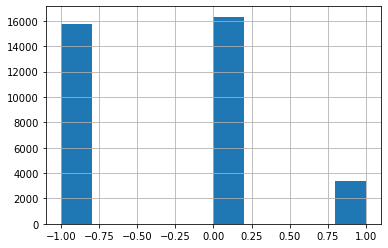

In [34]:
full_data['trend_num'].hist()

## Correlations

### Logistic Regression on Trend per Feature

See: https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365#:~:text=A%20simple%20approach%20could%20be,variance%20of%20the%20continuous%20variable.&text=If%20the%20variables%20have%20no,similar%20to%20the%20original%20variance.

In [35]:
full_data = full_data.dropna()

In [36]:
full_data = full_data[full_data['trend'] != 'Unknown']

In [37]:
clf = LogisticRegression(random_state=RANDOM_STATE)
runs = []
for col in full_data.columns.values:
    if (full_data[col].dtype == 'int64') | (full_data[col].dtype == 'float64'):
        y = full_data['trend'].copy()
        #y[y.isna()] = 'NULL'
        X = full_data[col]
        X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33, stratify=y,
                                                    random_state=RANDOM_STATE, shuffle=True)
        X_train = np.array(X_train).reshape(-1,1)
        X_test =  np.array(X_test).reshape(-1,1)
        y_train = np.array(y_train)
        y_test = np.array(y_test)
        clf.fit(X_train, y_train)
        
        y_hat = clf.predict(X_test)
        acc = clf.score(X_test, y_test)
        
        entry = {'column': col, 'acc': acc, 'y': y_test, 'y_hat':y_hat}
        runs.append(entry)
        print('{} predictor accuracy: {}'.format(col, acc))
    # acc_per_col[col] = 

perc_area_protected_all_obj predictor accuracy: 0.4647477083868757
perc_area_protected_obj_2 predictor accuracy: 0.46140666495331106
perc_area_protected_obj_3 predictor accuracy: 0.46140666495331106
perc_area_protected_obj_4 predictor accuracy: 0.46140666495331106
perc_area_protected_obj_1a predictor accuracy: 0.46140666495331106
perc_area_protected_obj_1b predictor accuracy: 0.46140666495331106
perc_area_protected_no_obj predictor accuracy: 0.4651760472886147
perc_area_protected_obj_5 predictor accuracy: 0.46269168165852825
perc_area_protected_obj_6 predictor accuracy: 0.46140666495331106
Artificial surfaces predictor accuracy: 0.46080699049087637
Bare area predictor accuracy: 0.46140666495331106
Cropland predictor accuracy: 0.46663239955452757
Grassland predictor accuracy: 0.46140666495331106
Inland water predictor accuracy: 0.46140666495331106
Shrubland predictor accuracy: 0.46140666495331106
Sparse vegetation predictor accuracy: 0.4778548787800908
Tree cover predictor accuracy: 0.4

In [38]:
run_df = pd.DataFrame(runs) 

In [39]:
run_df['y'].apply(lambda x: print(x))

['Decreasing' 'Stable' 'Increasing' ... 'Decreasing' 'Stable' 'Stable']
['Decreasing' 'Stable' 'Increasing' ... 'Decreasing' 'Stable' 'Stable']
['Decreasing' 'Stable' 'Increasing' ... 'Decreasing' 'Stable' 'Stable']
['Decreasing' 'Stable' 'Increasing' ... 'Decreasing' 'Stable' 'Stable']
['Decreasing' 'Stable' 'Increasing' ... 'Decreasing' 'Stable' 'Stable']
['Decreasing' 'Stable' 'Increasing' ... 'Decreasing' 'Stable' 'Stable']
['Decreasing' 'Stable' 'Increasing' ... 'Decreasing' 'Stable' 'Stable']
['Decreasing' 'Stable' 'Increasing' ... 'Decreasing' 'Stable' 'Stable']
['Decreasing' 'Stable' 'Increasing' ... 'Decreasing' 'Stable' 'Stable']
['Decreasing' 'Stable' 'Increasing' ... 'Decreasing' 'Stable' 'Stable']
['Decreasing' 'Stable' 'Increasing' ... 'Decreasing' 'Stable' 'Stable']
['Decreasing' 'Stable' 'Increasing' ... 'Decreasing' 'Stable' 'Stable']
['Decreasing' 'Stable' 'Increasing' ... 'Decreasing' 'Stable' 'Stable']
['Decreasing' 'Stable' 'Increasing' ... 'Decreasing' 'Stable' 'S

0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
18    None
19    None
20    None
21    None
22    None
23    None
24    None
25    None
26    None
27    None
28    None
Name: y, dtype: object

### Pearson Correlation


In [40]:
df_zscore = full_data.copy()
df_zscore['trend'] = full_data['trend']
df_zscore = z_score_normalize(df_zscore)


NameError: name 'zscore' is not defined

In [ ]:
df_zscore.describe()


#### Plot Correlation Matrix

In [ ]:
correlation_matrix =  df_zscore.corr(method= 'pearson')
#visualization of the correlation matrix as heatmap

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
ax.set_title('Correlation heatmap')

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# create heatmap
sns.heatmap(correlation_matrix, mask=mask,  cmap=cmap, vmin=-1, vmax=1, center=0)
plt.show()

## Modelling

### Group Data by Country and Kingdom. Mean aggregate

In [ ]:
by_country_kingdom = full_data.groupby(['kingdom_class', 'Country']).mean()
by_country_kingdom = by_country_kingdom.reset_index(drop=False)

In [ ]:
by_country_kingdom['trend_num'].hist()


### Rescale to [-1, 1]

In [ ]:
scaler = MinMaxScaler(feature_range=(-1,1))
by_country_kingdom['trend_num'] = scaler.fit_transform(np.array(by_country_kingdom['trend_num']).reshape(-1, 1))

In [ ]:
by_country_kingdom['trend_num'].hist()


In [ ]:
by_country_kingdom['kingdom_class'].unique()


In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(by_country_kingdom[['kingdom_class', 'Country']])

In [ ]:
enc.transform(by_country_kingdom[['kingdom_class', 'Country']])


In [ ]:
by_country_kingdom.drop(['kingdom_class', 'Country'], axis=1).describe()


# Relative Threatened Species

## Check correlation of our features and target values for the relative threatened species by country and group 

For our correlation analysis, we exclude our non continuous variables (the binary value whether a taxonomic group has records for that specific country)

In [ ]:
full_threatened_corr = full_threatened.copy()
full_threatened_corr = full_threatened.drop(columns=['mammals_resident', 'insects_resident', "amphibians_resident", "birds_resident", "reptiles_resident"])

In [ ]:
#full correlation matrix to also get an overview of correlations between different features
full_threatened_corr.corr(method= 'pearson')

In [ ]:
#visualization of the correlation matrix as heatmap

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
ax.set_title('Correlation heatmap')

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# create heatmap
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0)
plt.show()

To get a better overview of our targets we calculate the correlation of the features with each target separately

In [ ]:
#pearsons rho for the correlation of the values for all groups with our features
for col in full_threatened_corr:
    target = 'total_threatened'
    exclude =  ['Country','total_threatened', 'mammals_threatened', 'insects_threatened', 'amphibians_threatened','birds_threatened', 'reptiles_threatened']
    correlations = {}
    if col not in exclude:
        correlations[col + ' pearsons correlation with ' + target] = round(full_threatened_corr[col].corr(full_threatened_corr[target]),5)
        print(correlations)

In [ ]:
#pearsons rho for the correlation of the threatened mammals with our features
for col in full_threatened_corr:
    target = 'mammals_threatened'
    exclude =  ['Country','total_threatened', 'mammals_threatened', 'insects_threatened', 'amphibians_threatened','birds_threatened', 'reptiles_threatened']
    correlations = {}
    if col not in exclude:
        correlations[col + ' pearsons correlation with ' + target] = round(full_threatened_corr[col].corr(full_threatened_corr[target]),5)
        print(correlations)

In [ ]:
#pearsons rho for the correlation of the threatened insects with our features
for col in full_threatened_corr:
    target = 'insects_threatened'
    exclude =  ['Country','total_threatened', 'mammals_threatened', 'insects_threatened', 'amphibians_threatened','birds_threatened', 'reptiles_threatened']
    correlations = {}
    if col not in exclude:
        correlations[col + ' pearsons correlation with ' + target] = round(full_threatened_corr[col].corr(full_threatened_corr[target]),5)
        print(correlations)

In [ ]:
#pearsons rho for the correlation of the threatened amphibians with our features
for col in full_threatened_corr:
    target = 'amphibians_threatened'
    exclude =  ['Country','total_threatened', 'mammals_threatened', 'insects_threatened', 'amphibians_threatened','birds_threatened', 'reptiles_threatened']
    correlations = {}
    if col not in exclude:
        correlations[col + ' pearsons correlation with ' + target] = round(full_threatened_corr[col].corr(full_threatened_corr[target]),5)
        print(correlations)

In [ ]:
#pearsons rho for the correlation of the threatened birds with our features
for col in full_threatened_corr:
    target = 'birds_threatened'
    exclude =  ['Country','total_threatened', 'mammals_threatened', 'insects_threatened', 'amphibians_threatened','birds_threatened', 'reptiles_threatened']
    correlations = {}
    if col not in exclude:
        correlations[col + ' pearsons correlation with ' + target] = round(full_threatened_corr[col].corr(full_threatened_corr[target]),5)
        print(correlations)

In [ ]:
#pearsons rho for the correlation of the threatened reptiles with our features
for col in full_threatened_corr:
    target = 'reptiles_threatened'
    exclude =  ['Country','total_threatened', 'mammals_threatened', 'insects_threatened', 'amphibians_threatened','birds_threatened', 'reptiles_threatened']
    correlations = {}
    if col not in exclude:
        correlations[col + ' pearsons correlation with ' + target] = round(full_threatened_corr[col].corr(full_threatened_corr[target]),5)
        print(correlations)

### Conclusion
We can see many major difference between the groups regarding the correlation to each feature. One thing that can be seen is that sparse vegetation correlates stronger with the number of threatened mammals than with any other group. Overall we can see the highest positive correlation for the amount of shrubland of a country and the highest negative correlation for nitrous oxide. As we divided the features into four groups (protected areas, land cover, temperature and greenhouse gases), we can see that for every group we have at least some variables that contributed to the prediction of our targets, so we decide to keep those four groups for our model building process and start with the full model.